This notebook will hopefully contain timeseries that plot continuous data from moorings alongside model output For all depths. For now, it is focussing on just plotting model output for all depths. 

In [1]:
import sys
sys.path.append('/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import xarray as xr
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools, places
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import math
from scipy import io
import pickle
import cmocean
import json
import Keegan_eval_tools as ket
from collections import OrderedDict
from matplotlib.colors import LogNorm

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [3]:
# find a more appropriate name then saveloc
saveloc1='/ocean/kflanaga/MEOPAR/ptrc_extractions'
saveloc2='/ocean/kflanaga/MEOPAR/grid_extractions'
dataloc='/ocean/kflanaga/MEOPAR/ORCAData'
PATH='/results2/SalishSea/nowcast-green.201905/'
year=2019
Mooring='Hoodsport'

In [4]:
orca_dict=io.loadmat(f'{dataloc}/{Mooring}.mat')

In [5]:
def ORCA_dd_to_dt(date_list):
    UTC=[]
    for yd in date_list:
        if np.isnan(yd) == True:
            UTC.append(float("NaN"))
        else:
            start = dt.datetime(1999,12,31)      
            delta = dt.timedelta(yd)     
            offset = start + delta
            time=offset.replace(microsecond=0)
            UTC.append(time)
    return UTC

In [6]:
obs_dep=[]
for i in orca_dict['Bdepth']:
    obs_dep.append(np.nanmean(i))

<ipython-input-6-5c06f2d5d6a3>:3: RuntimeWarning: Mean of empty slice
  obs_dep.append(np.nanmean(i))


In [7]:
obs_tt=[]
for i in range(len(orca_dict['Btime'][1])):
    obs_tt.append(np.nanmean(orca_dict['Btime'][:,i]))
#I should also change this obs_tt thing I have here into datetimes    
YD_rounded=[]
for yd in obs_tt:
    if np.isnan(yd) == True:
        YD_rounded.append(float("NaN"))
    else:
        YD_rounded.append(math.floor(yd))

<ipython-input-7-56777448cb66>:3: RuntimeWarning: Mean of empty slice
  obs_tt.append(np.nanmean(orca_dict['Btime'][:,i]))


In [8]:
obs_tt=[]
for i in range(len(orca_dict['Btime'][1])):
    obs_tt.append(np.nanmean(orca_dict['Btime'][:,i]))
#I should also change this obs_tt thing I have here into datetimes    
YD_rounded=[]
for yd in obs_tt:
    if np.isnan(yd) == True:
        YD_rounded.append(float("NaN"))
    else:
        YD_rounded.append(math.floor(yd))
obs_dep=[]
for i in orca_dict['Bdepth']:
    obs_dep.append(np.nanmean(i))

<ipython-input-8-df801a97040c>:3: RuntimeWarning: Mean of empty slice
  obs_tt.append(np.nanmean(orca_dict['Btime'][:,i]))
<ipython-input-8-df801a97040c>:13: RuntimeWarning: Mean of empty slice
  obs_dep.append(np.nanmean(i))


In [9]:
def Process_ORCA(orca_var,depths,dates,year):
    df_1=pd.DataFrame(orca_var).transpose()
    df_YD=pd.DataFrame(dates,columns=['yearday'])
    df_1=pd.concat((df_1,df_YD),axis=1)
    dfg=df_1.groupby(by='yearday')
    df_mean=dfg.mean()
    df_mean=df_mean.reset_index()
    UTC=ORCA_dd_to_dt(df_mean['yearday'])
    df_mean['yearday']=UTC
    df_year=df_mean[(df_mean.yearday >= dt.datetime(year,1,1))&(df_mean.yearday <= dt.datetime(year,12,31))]
    df_year=df_year.set_index('yearday')
    idx=pd.date_range(df_year.index[1],df_year.index[-1])
    df_full=df_year.reindex(idx,fill_value=-1)
    df_full=df_full.transpose()
    df_full['depth']=obs_dep
    df_full=df_full.dropna(how='all',subset=['depth'])
    df_full=df_full.set_index('depth')
    df_final=np.ma.masked_invalid(np.array(df_full))
    df_final=np.ma.masked_less(df_final,0)
    return df_final, df_full.index, df_full.columns

In [10]:
# I think I prefer the pcolourmesh style of plotting. 
def hovmoeller(variable, depth, dates_list, depth_range, title='',var_title='', vmin=float('NaN'), vmax=float('NaN'),cmap='jet'):
    depth_min, depth_max = depth_range
    if np.isnan(vmin) == True:
        vmin= variable.min()
    if np.isnan(vmax) == True:
        vmax= variable.max()
    fig, ax = plt.subplots(1,1, figsize=(12,6))

    # Plot temperature contours
    #CB = ax.contourf(dates_list, depth, np.transpose(variable),
    #                    vmin=var_min, vmax=var_max)
    CB=ax.pcolormesh(dates_list, depth, variable, shading='auto',
               vmin=vmin, vmax=vmax, cmap=cmap)

    #Once you have the data from a whole year these should be used to divide seasons. 
    #ax.axvline(x=dt.datetime(2017,8,1), linestyle='-', linewidth=2.0, c='w')
    #ax.axvline(x=dt.datetime(2018,8,1), linestyle='-', linewidth=2.0, c='w')
    #ax.axvline(x=dt.datetime(2019,8,1), linestyle='-', linewidth=2.0, c='w')

    # Settings
    ax.set_title(title)
    ax.invert_yaxis()
    ax.set_xlabel('Date')
    ax.set_ylabel('Depth [m]')
    ax.set_ylim(depth_max,depth_min)
    yearsFmt = mdates.DateFormatter('%d %b')
    ax.xaxis.set_major_formatter(yearsFmt)
    plt.tight_layout()
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    plt.locator_params(axis="x", nbins=20)
    
    # Colorbar:
    cbar_ax = fig.add_axes([1, 0.35, 0.02, 0.52])
    cbar    = fig.colorbar(CB, cax=cbar_ax, ticks=np.linspace(vmin,vmax,8))
    cbar.set_label(var_title)
    
    return

In [11]:
df,dep,tim= Process_ORCA(orca_dict['Btemp'],obs_dep,YD_rounded,2015)

<ipython-input-10-7bec8a610347>:31: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis="x", nbins=20)


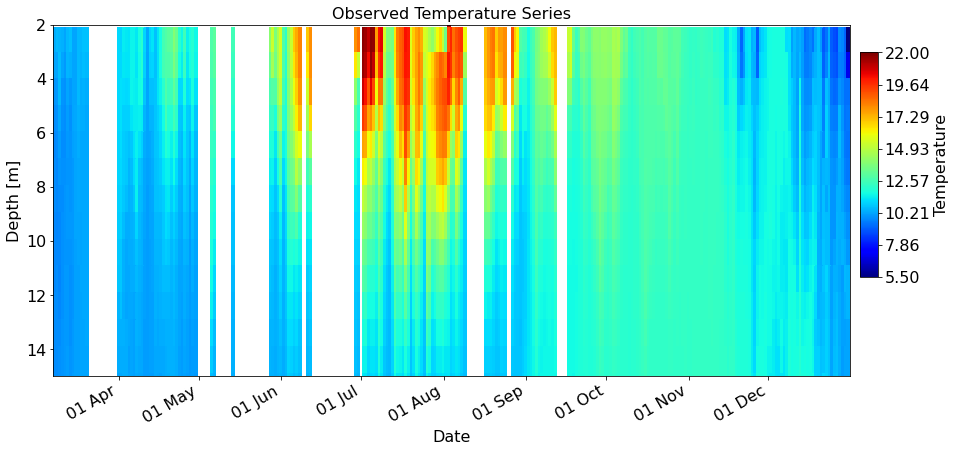

In [13]:
hovmoeller(df,dep,tim,(2,15),title='Observed Temperature Series',var_title='Temperature',vmax=22,vmin=5.5)

In [14]:
df,dep,tim= Process_ORCA(orca_dict['Bsal'],obs_dep,YD_rounded,2015)

<ipython-input-10-7bec8a610347>:31: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis="x", nbins=20)


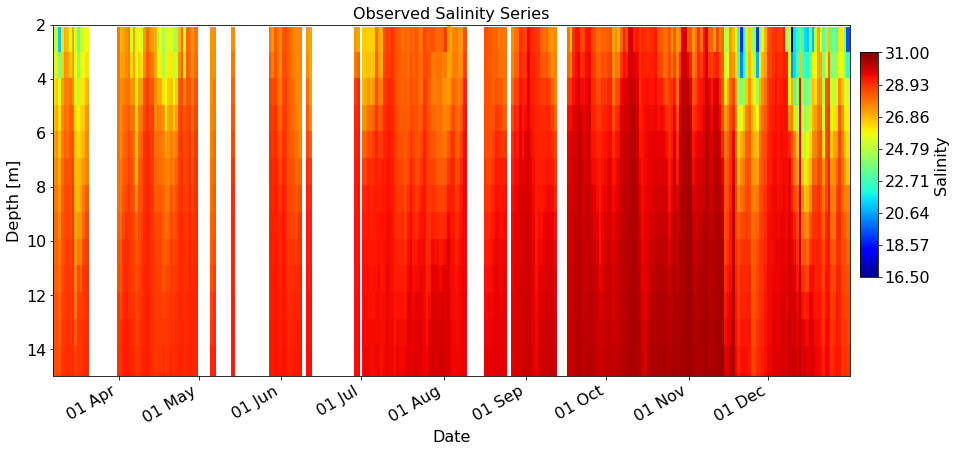

In [15]:
hovmoeller(df,dep,tim,(2,15),title='Observed Salinity Series',var_title='Salinity',vmax=31,vmin=16.5)

In [16]:
grid=xr.open_mfdataset(saveloc2+'/ts_HC201905_2015_Hoodsport.nc')

In [26]:
tt

array(['2015-01-01T00:30:00.000000000', '2015-01-01T01:30:00.000000000',
       '2015-01-01T02:30:00.000000000', ...,
       '2015-12-31T21:30:00.000000000', '2015-12-31T22:30:00.000000000',
       '2015-12-31T23:30:00.000000000'], dtype='datetime64[ns]')

In [27]:
np.datetime64('2015-03-01')

numpy.datetime64('2015-03-01')

array(['2015-03-01T00:30:00.000000000', '2015-03-01T01:30:00.000000000',
       '2015-03-01T02:30:00.000000000', ...,
       '2015-12-31T21:30:00.000000000', '2015-12-31T22:30:00.000000000',
       '2015-12-31T23:30:00.000000000'], dtype='datetime64[ns]')

In [32]:
%%time
tt=np.array(grid.time_counter)
mod_depth=np.array(grid.deptht)
mod_temper=(grid.votemper.isel(y=0,x=0))
mod_saline=(grid.vosaline.isel(y=0,x=0))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.41 ms


Wait, can I do this with three 1d arrays rather than 1 2d array? 

In [33]:
temperature = (np.array(mod_temper))
temperature = np.ma.masked_equal(temperature,0)
temperature = temperature.T
salinity = (np.array(mod_saline))
salinity = np.ma.masked_equal(salinity,0).T

<ipython-input-10-7bec8a610347>:31: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis="x", nbins=20)


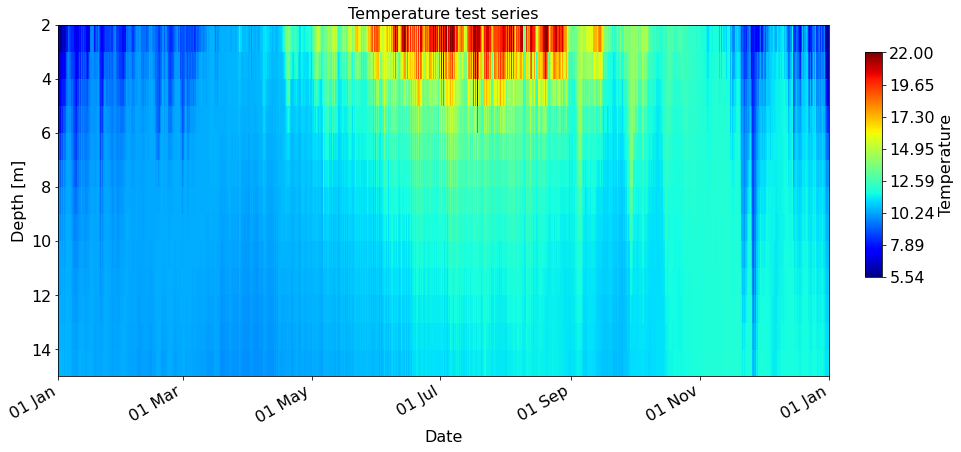

In [34]:
hovmoeller(temperature, mod_depth, tt, (2,15), title='Temperature test series',var_title='Temperature',vmax=22,vmin=5.54)

<ipython-input-10-7bec8a610347>:31: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis="x", nbins=20)


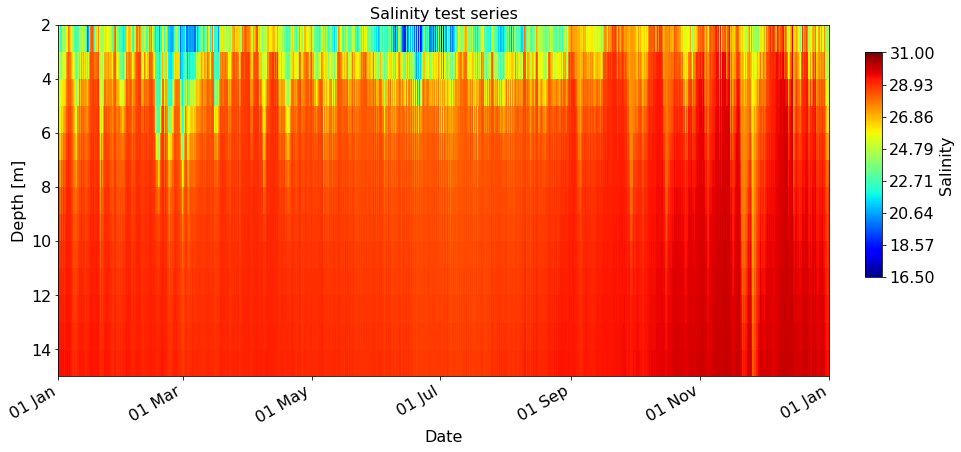

In [35]:
hovmoeller(salinity, mod_depth, tt, (2,15), title='Salinity test series',var_title='Salinity',vmax=31,vmin=16.5)

In [124]:
grid.close()